In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import wrds

from scipy.stats import norm

In [2]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='lilas_bertot')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!

Loading library list...
Done


In [3]:
# Extraction des données CRSP

# Liste des symboles d'actions
stocks = ['V', 'LNC', 'LPLA', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']
stocks_str = "', '".join(stocks)

stock_query = f"""
SELECT a.date, b.ticker, a.permno, a.ret, a.prc, a.shrout, a.vol,
        a.bid, a.ask
FROM crsp.dsf a
INNER JOIN crsp.dsenames b ON a.permno = b.permno
WHERE b.ticker IN ('{stocks_str}')
AND a.date >= '2011-01-01' 
AND a.date <= '2024-12-31'
AND a.date >= b.namedt 
AND a.date <= b.nameendt
ORDER BY b.ticker, a.date
"""

stock_data_filtered = db.raw_sql(stock_query, date_cols=['date'])

for stock in stocks:
    stock_count = len(stock_data_filtered[stock_data_filtered['ticker'] == stock])
    print(f"{stock}: {stock_count} observations")

V: 3522 observations
LNC: 3522 observations
LPLA: 3522 observations
VRSN: 3522 observations
LRCX: 3522 observations
LOGI: 3522 observations
VLO: 3522 observations
LYB: 3522 observations
DVN: 3522 observations


In [4]:
# Extraction des données SPX
print("🔍 Exécution de la requête SQL pour SPX...")

spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi 
WHERE date >= '2011-01-01' 
AND date <= '2024-12-31'
AND spindx IS NOT NULL
ORDER BY date
"""

spx_data = db.raw_sql(spx_query, date_cols=['date'])

# Calcul des rendements
spx_data = spx_data.sort_values('date')
spx_data['ret'] = spx_data['prc'].pct_change()

spx_data.info()
spx_data

🔍 Exécution de la requête SQL pour SPX...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [5]:
# Aperçu des données
stock_data_filtered.info()
stock_data_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31698 entries, 0 to 31697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31698 non-null  datetime64[ns]
 1   ticker  31698 non-null  string        
 2   permno  31698 non-null  Int64         
 3   ret     31698 non-null  Float64       
 4   prc     31698 non-null  Float64       
 5   shrout  31698 non-null  Float64       
 6   vol     31698 non-null  Float64       
 7   bid     31698 non-null  Float64       
 8   ask     31698 non-null  Float64       
dtypes: Float64(6), Int64(1), datetime64[ns](1), string(1)
memory usage: 2.4 MB


,date,ticker,permno,ret,prc,shrout,vol,bid,ask
0,2011-01-03,DVN,87137,0.002165,78.68,431900.0,2557300.0,78.63,78.64
1,2011-01-04,DVN,87137,-0.006101,78.2,431900.0,2875800.0,78.16,78.17
2,2011-01-05,DVN,87137,0.006394,78.7,431900.0,2885000.0,78.69,78.71
3,2011-01-06,DVN,87137,-0.005972,78.23,431900.0,2462300.0,78.24,78.25
4,2011-01-07,DVN,87137,0.00294,78.46,431900.0,1830900.0,78.47,78.49
...,...,...,...,...,...,...,...,...,...
31693,2024-12-24,VRSN,85753,0.007601,201.48,96100.0,215237.0,201.32001,201.48
31694,2024-12-26,VRSN,85753,0.006204,202.73,96100.0,365131.0,202.62,202.71001
31695,2024-12-27,VRSN,85753,0.006018,203.95,96100.0,564782.0,203.92999,204.03
31696,2024-12-30,VRSN,85753,0.005639,205.10001,96100.0,890432.0,205.08,205.17999


In [6]:
spx_data.info()
spx_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [8]:
# 3 janvier 2012 au 3 janvier 2023
start_date = '2012-01-03'
end_date = '2023-01-03'

# Titres à analyser pour l'approche sectorielle complète
# Secteur Technologie: VRSN (VeriSign), LRCX (Lam Research), LOGI (Logitech)
# Secteur Énergie: VLO (Valero Energy), LYB (LyondellBasell), DVN (Devon Energy)
# Autres: V (Visa), LNC (Lincoln National), LPLA (LPL Financial)
titles_to_analyze = {
    'SPX': spx_data[(spx_data['date'] >= start_date) & (spx_data['date'] <= end_date)],
    'V': stock_data_filtered[(stock_data_filtered['ticker'] == 'V') & 
                             (stock_data_filtered['date'] >= start_date) & 
                             (stock_data_filtered['date'] <= end_date)],
    'LNC': stock_data_filtered[(stock_data_filtered['ticker'] == 'LNC') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LPLA': stock_data_filtered[(stock_data_filtered['ticker'] == 'LPLA') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'VRSN': stock_data_filtered[(stock_data_filtered['ticker'] == 'VRSN') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LRCX': stock_data_filtered[(stock_data_filtered['ticker'] == 'LRCX') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LOGI': stock_data_filtered[(stock_data_filtered['ticker'] == 'LOGI') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'VLO': stock_data_filtered[(stock_data_filtered['ticker'] == 'VLO') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LYB': stock_data_filtered[(stock_data_filtered['ticker'] == 'LYB') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'DVN': stock_data_filtered[(stock_data_filtered['ticker'] == 'DVN') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)]
}

market_index = {'SPX': titles_to_analyze['SPX']}
tech_sector = {
    'VRSN': titles_to_analyze['VRSN'],
    'LRCX': titles_to_analyze['LRCX'],
    'LOGI': titles_to_analyze['LOGI']
}
energy_sector = {
    'VLO': titles_to_analyze['VLO'],
    'LYB': titles_to_analyze['LYB'],
    'DVN': titles_to_analyze['DVN']
}
finance_sector = {
    'V': titles_to_analyze['V'],
    'LNC': titles_to_analyze['LNC'],
    'LPLA': titles_to_analyze['LPLA']
}

## QUESTION a

Analyse de Indice de marché (SPX)
Statistiques descriptives des rendements - SPX:
count      2769.0
mean     0.000461
std      0.010842
min     -0.119841
25%     -0.003702
50%      0.000582
75%      0.005369
max      0.093828
Name: ret, dtype: Float64


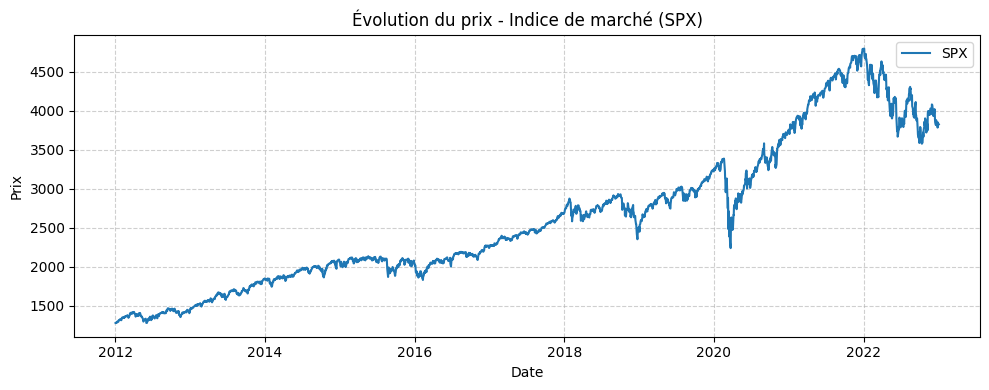

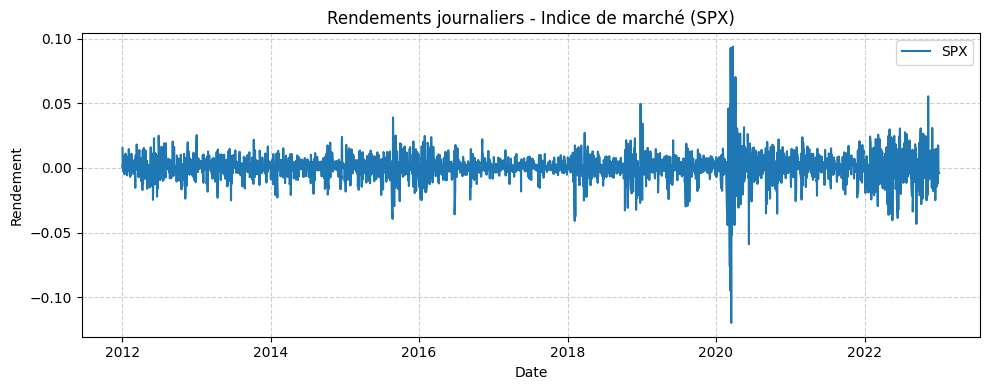

Analyse de Secteur Technologie
Statistiques descriptives des rendements - VRSN:
count      2769.0
mean     0.000765
std      0.016672
min     -0.154721
25%     -0.006727
50%      0.001231
75%      0.008626
max      0.172017
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LRCX:
count      2769.0
mean     0.001211
std      0.024158
min     -0.184277
25%     -0.010666
50%      0.001142
75%      0.013074
max      0.201919
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LOGI:
count      2769.0
mean     0.001126
std      0.023199
min     -0.191825
25%      -0.00965
50%      0.000667
75%      0.011402
max      0.227685
Name: ret, dtype: Float64


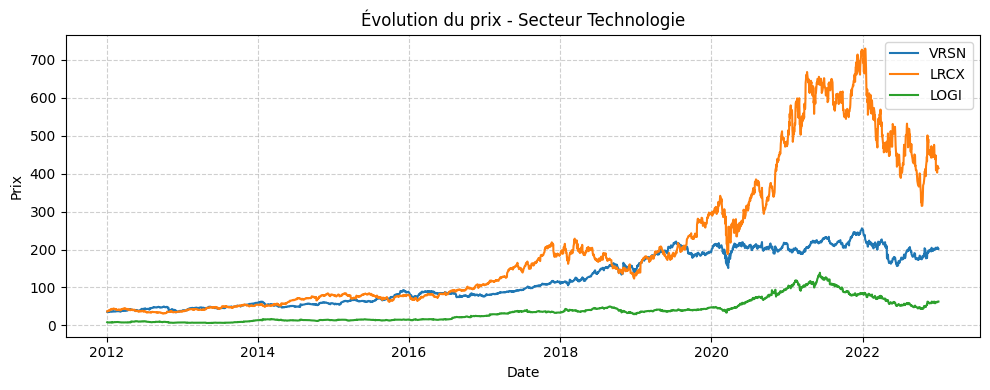

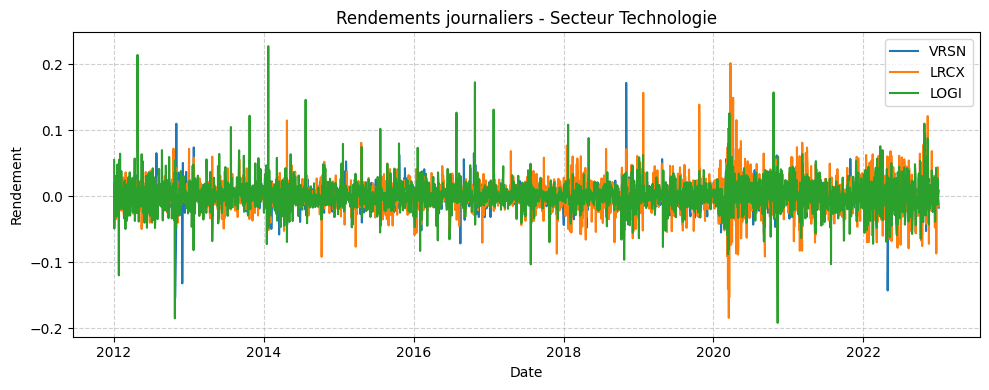

Analyse de Secteur Énergie
Statistiques descriptives des rendements - VLO:
count      2769.0
mean     0.001111
std      0.024739
min     -0.192209
25%     -0.010691
50%      0.001143
75%      0.013335
max      0.312025
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LYB:
count      2769.0
mean     0.000788
std       0.02213
min      -0.25491
25%     -0.009726
50%      0.000619
75%       0.01149
max      0.195415
Name: ret, dtype: Float64
Statistiques descriptives des rendements - DVN:
count      2769.0
mean     0.000574
std      0.031002
min     -0.373972
25%     -0.014061
50%           0.0
75%      0.014749
max      0.210721
Name: ret, dtype: Float64


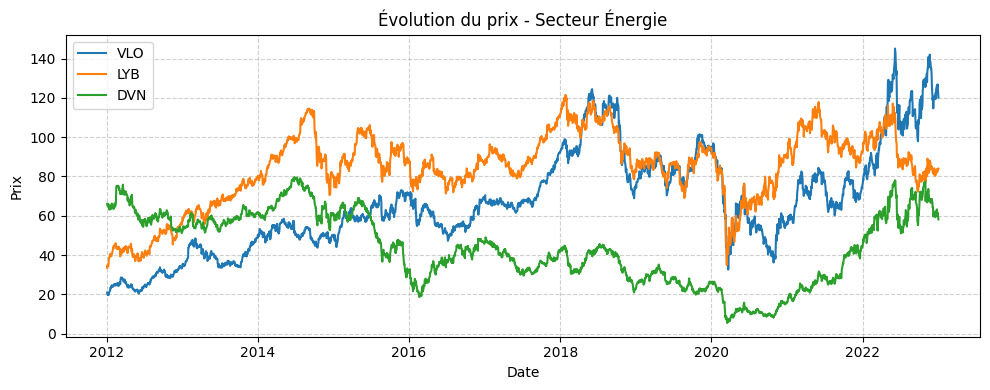

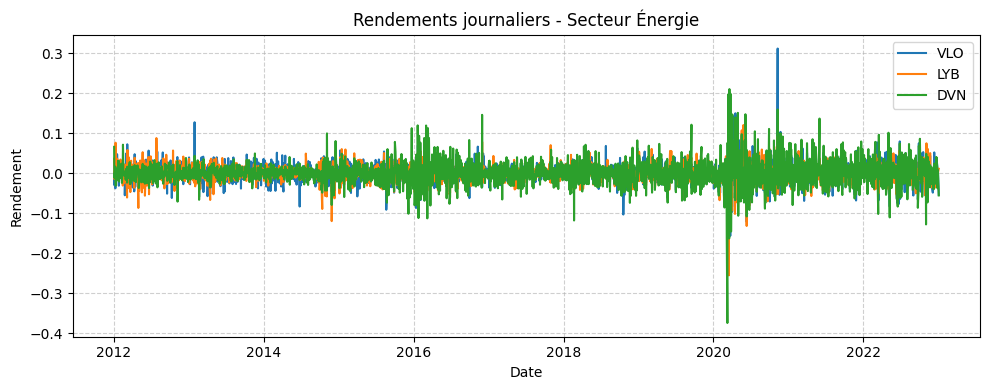

Analyse de Secteur Finance
Statistiques descriptives des rendements - V:
count      2769.0
mean     0.000909
std      0.015642
min     -0.135472
25%     -0.006813
50%      0.001313
75%       0.00875
max      0.138426
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LNC:
count      2769.0
mean     0.000629
std      0.027164
min     -0.331478
25%     -0.010658
50%      0.000964
75%      0.012797
max      0.317003
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LPLA:
count      2769.0
mean     0.001076
std      0.023337
min     -0.346793
25%     -0.008736
50%      0.001374
75%      0.012078
max      0.247351
Name: ret, dtype: Float64


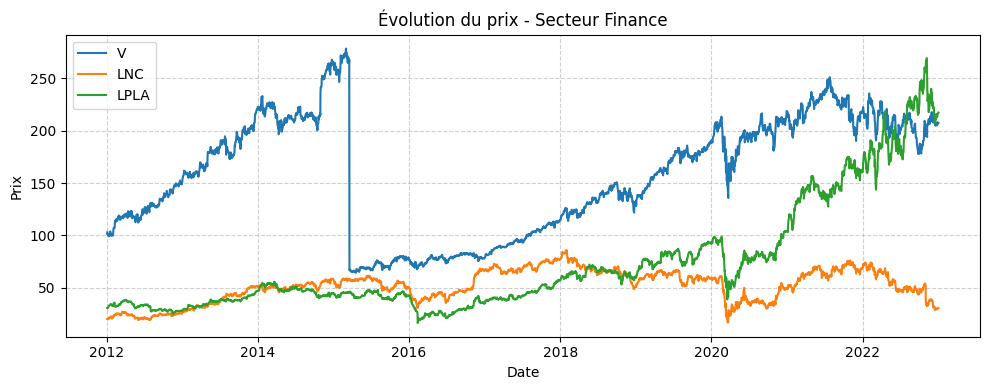

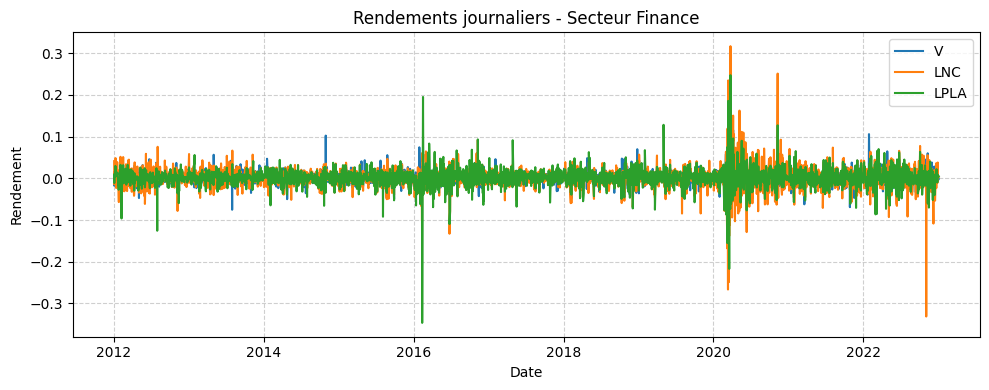

In [12]:
def analyze_sector(sector_name, sector_dict):
    print(f"Analyse de {sector_name}")

    # Statistiques descriptives
    for ticker, df in sector_dict.items():
        print(f"Statistiques descriptives des rendements - {ticker}:")
        print(df['ret'].describe())

    # Série chronologique prix 
    plt.figure(figsize=(10, 4))
    for ticker, df in sector_dict.items():
        df_sorted = df.sort_values('date')
        plt.plot(df_sorted['date'], df_sorted['prc'], label=ticker)
    plt.title(f"Évolution du prix - {sector_name}")
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Rendements 
    plt.figure(figsize=(10, 4))
    for ticker, df in sector_dict.items():
        df_sorted = df.sort_values('date')
        plt.plot(df_sorted['date'], df_sorted['ret'], label=ticker)
    plt.title(f"Rendements journaliers - {sector_name}")
    plt.xlabel('Date')
    plt.ylabel('Rendement')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_sector("Indice de marché (SPX)", market_index)
analyze_sector("Secteur Technologie", tech_sector)
analyze_sector("Secteur Énergie", energy_sector)
analyze_sector("Secteur Finance", finance_sector)

## QUESTION b
                               

In [14]:
# Titres à analyser
titles_for_var = {
    'SPX': titles_to_analyze['SPX'],
    'VRSN': titles_to_analyze['VRSN'],
    'LRCX': titles_to_analyze['LRCX'],
    'LOGI': titles_to_analyze['LOGI'],
    'VLO': titles_to_analyze['VLO'],
    'LYB': titles_to_analyze['LYB'],
    'DVN': titles_to_analyze['DVN'],
}

# Secteurs pour analyse sectorielle
sectors = {
    'Indice de marché': ['SPX'],
    'Secteur Technologie': ['VRSN', 'LRCX', 'LOGI'],
    'Secteur Énergie': ['VLO', 'LYB', 'DVN']
}

In [39]:
def compute_sector_var_es(tickers, titles_for_var, sector_name):
    returns_list = []
    for ticker in tickers:
        df = titles_for_var[ticker].copy()
        df = df.sort_values('date')
        df = df.set_index('date')
        returns_list.append(df['ret'].dropna())

    combined_returns = pd.concat(returns_list, axis=1)
    combined_returns.columns = tickers
    sector_returns = combined_returns.mean(axis=1).dropna()

    # VaR
    var_1 = sector_returns.quantile(0.01)
    var_5 = sector_returns.quantile(0.05)

    # ES 
    es_1 = sector_returns[sector_returns <= var_1].mean()
    es_5 = sector_returns[sector_returns <= var_5].mean()

    # Affichage formaté
    print(f"Résultats de {sector_name}")
    print(f"VaR à 1% : {var_1:.4%}")
    print(f"ES à 1% : {es_1:.4%}")
    print(f"VaR à 5% : {var_5:.4%}")
    print(f"ES à 5% : {es_5:.4%}")

print("\nRésultats empiriques")
for sector, tickers in sectors.items():
    compute_sector_var_es(tickers, titles_for_var, sector)



Résultats empiriques
Résultats de Indice de marché
VaR à 1% : -3.1911%
ES à 1% : -4.5193%
VaR à 5% : -1.6283%
ES à 5% : -2.6453%
Résultats de Secteur Technologie
VaR à 1% : -4.8247%
ES à 1% : -5.8529%
VaR à 5% : -2.4939%
ES à 5% : -3.8271%
Résultats de Secteur Énergie
VaR à 1% : -5.5015%
ES à 1% : -8.1292%
VaR à 5% : -3.2696%
ES à 5% : -4.9195%


## QUESTION c

In [40]:
def compute_parametric_var_es(tickers, titles_for_var, sector_name):
    returns_list = []

    for ticker in tickers:
        df = titles_for_var[ticker].copy()
        df = df.sort_values('date')
        df = df.set_index('date')
        returns_list.append(df['ret'].dropna())

    combined_returns = pd.concat(returns_list, axis=1)
    combined_returns.columns = tickers
    sector_returns = combined_returns.mean(axis=1).dropna()

    mu = sector_returns.mean()
    sigma = sector_returns.std()

    alpha_1 = 0.01
    alpha_5 = 0.05

    # VaR gaussienne
    var_1 = mu + sigma * norm.ppf(alpha_1)
    var_5 = mu + sigma * norm.ppf(alpha_5)

    # ES gaussienne
    es_1 = mu - sigma * norm.pdf(norm.ppf(alpha_1)) / alpha_1
    es_5 = mu - sigma * norm.pdf(norm.ppf(alpha_5)) / alpha_5

    print(f"Résultats paramétriques – {sector_name}")
    print(f"VaR à 1% : {var_1:.4%}")
    print(f"ES à 1% : {es_1:.4%}")
    print(f"VaR à 5% : {var_5:.4%}")
    print(f"ES à 5% : {es_5:.4%}")

print("\nRésultats paramétriques")
for sector, tickers in sectors.items():
    compute_parametric_var_es(tickers, titles_for_var, sector)



Résultats paramétriques
Résultats paramétriques – Indice de marché
VaR à 1% : -2.4762%
ES à 1% : -2.8436%
VaR à 5% : -1.7373%
ES à 5% : -2.1904%
Résultats paramétriques – Secteur Technologie
VaR à 1% : -3.7421%
ES à 1% : -4.3023%
VaR à 5% : -2.6156%
ES à 5% : -3.3063%
Résultats paramétriques – Secteur Énergie
VaR à 1% : -4.9320%
ES à 1% : -5.6624%
VaR à 5% : -3.4631%
ES à 5% : -4.3638%


## QUESTION d

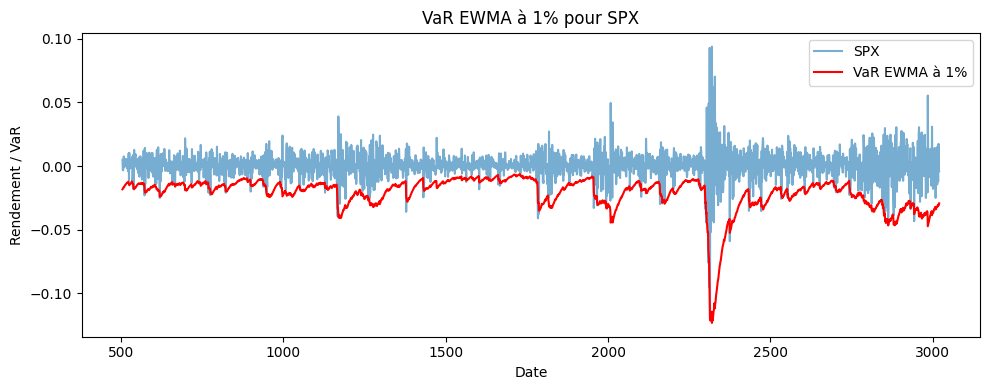

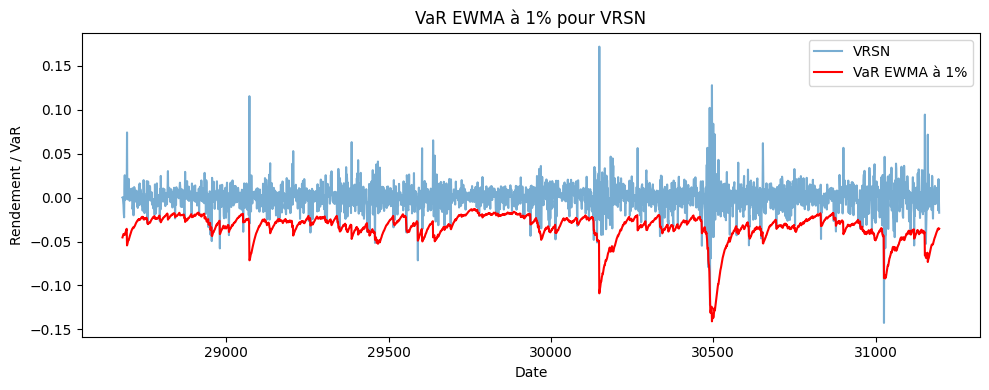

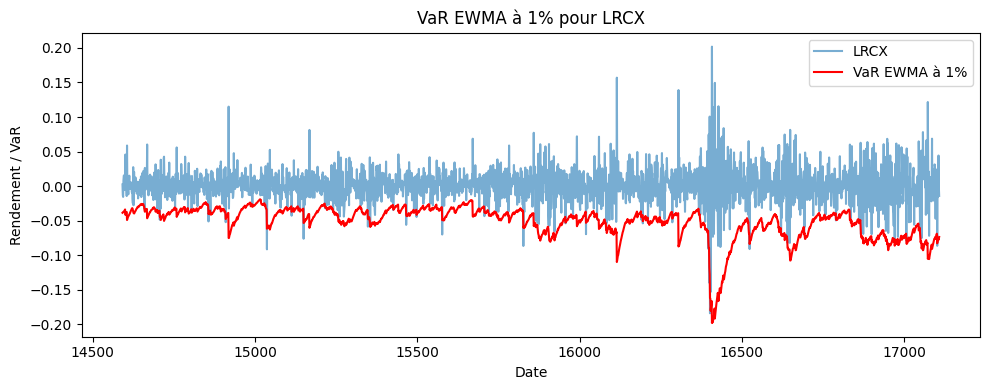

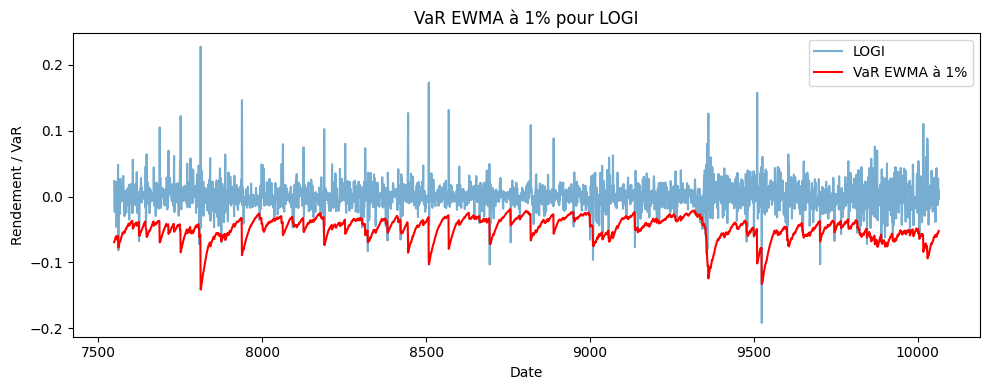

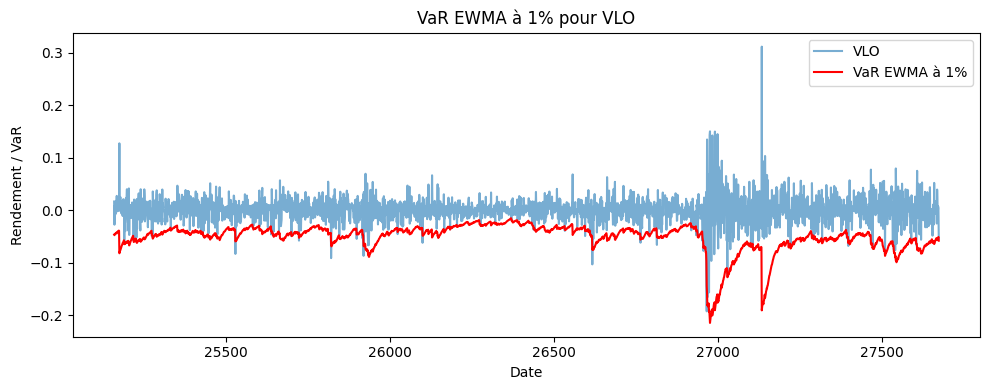

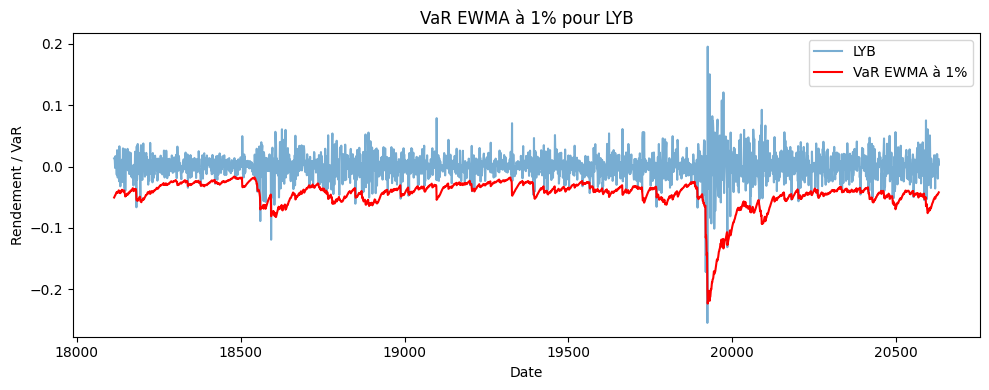

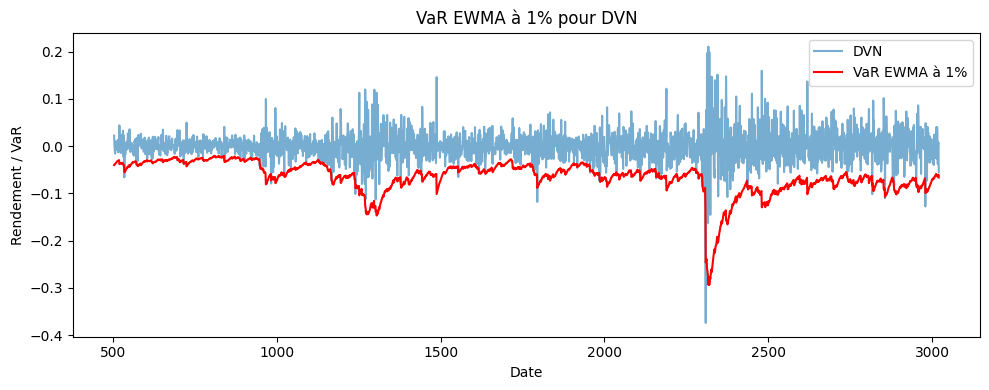

In [50]:
def plot_ewma_var_individual(tickers, titles_dict, lambda_=0.94, alpha=0.01):
    window = 252
    z = np.percentile(np.random.randn(100000), alpha * 100)

    for ticker in tickers:
        df = titles_dict[ticker].copy()
        returns = df['ret'].dropna()
        dates = returns.index

        ewma_var = [np.var(returns[:window])]
        for r in returns[window:]:
            new_var = lambda_ * ewma_var[-1] + (1 - lambda_) * r**2
            ewma_var.append(new_var)

        sigma = np.sqrt(ewma_var)
        mu = returns.mean()
        var_series = mu + z * sigma

        var_dates = dates[window:]
        realized_returns = returns[window:]

        # Tracer
        plt.figure(figsize=(10, 4))
        plt.plot(var_dates, realized_returns, label=ticker, alpha=0.6)
        plt.plot(var_dates, var_series[1:], label='VaR EWMA à 1%', color='red')
        plt.title(f'VaR EWMA à 1% pour {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Rendement / VaR')
        plt.legend()
        plt.tight_layout()
        plt.show()

all_tickers = ['SPX', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']

plot_ewma_var_individual(all_tickers, titles_for_var)

## QUESTION e

In [51]:
# Création choc (7 jours)
def generate_shock(last_date):
    start_date = pd.to_datetime("2016-12-31")
    shock_dates = pd.bdate_range(start=start_date, periods=7)
    shock_returns = pd.Series([-0.11, -0.09, -0.08, -0.07, -0.05, -0.03, -0.02], index=shock_dates)
    shock_returns.index.name = 'date'
    return shock_returns

In [52]:
# VaR Historique 
def var_historique(x, alpha=0.01):
    return np.quantile(x, alpha)

# VaR Gaussienne 
def var_gaussienne(returns, window, alpha=0.01):
    mu = returns.rolling(window).mean()
    sigma = returns.rolling(window).std()
    z = norm.ppf(alpha)
    return mu + z * sigma

# VaR Récursive
def var_ewma(returns, alpha=0.01, lambda_=0.94):
    ewma_var = []
    squared_returns = returns**2
    var = squared_returns.iloc[0] 
    for r2 in squared_returns:
        var = lambda_ * var + (1 - lambda_) * r2
        ewma_var.append(var)
    ewma_vol = np.sqrt(pd.Series(ewma_var, index=returns.index))
    z = norm.ppf(alpha)
    return z * ewma_vol

Analyse de l'impact du choc pour SPX dans le Indice de marché


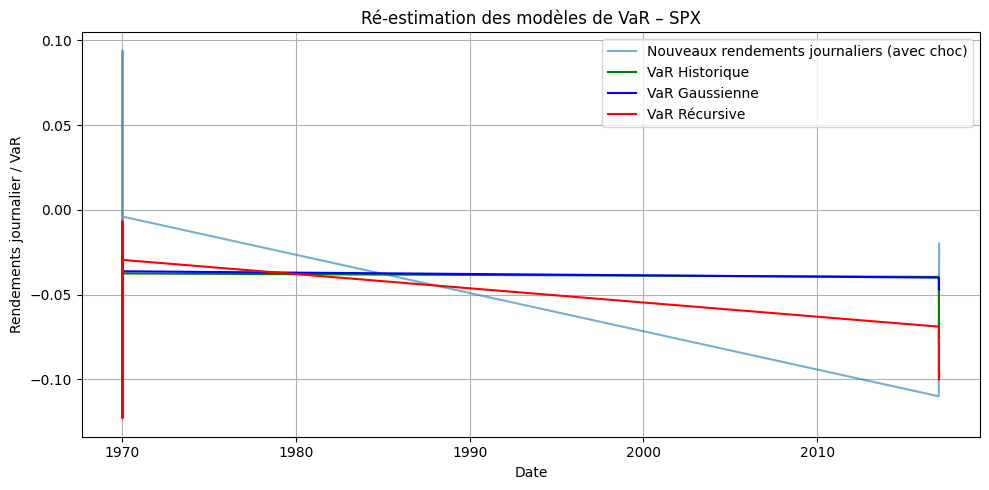

Analyse de l'impact du choc pour VRSN dans le Secteur Technologie


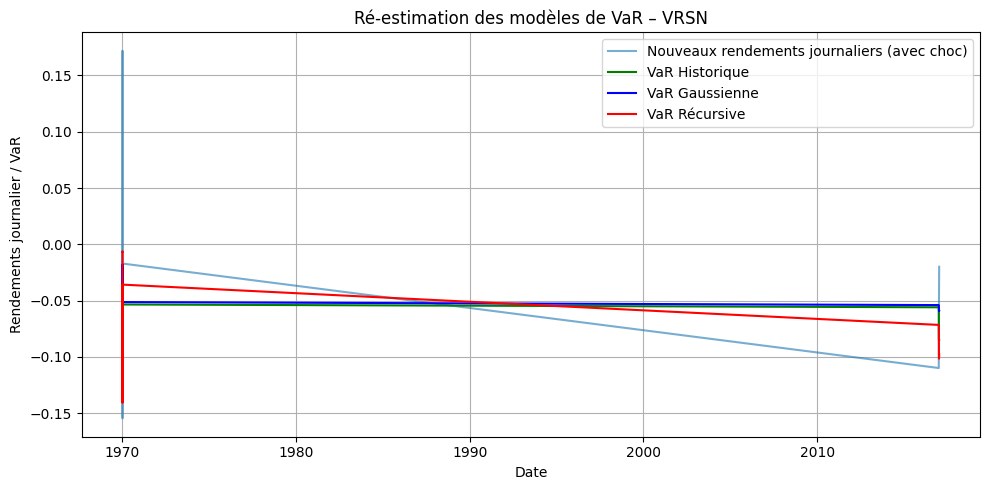

Analyse de l'impact du choc pour LRCX dans le Secteur Technologie


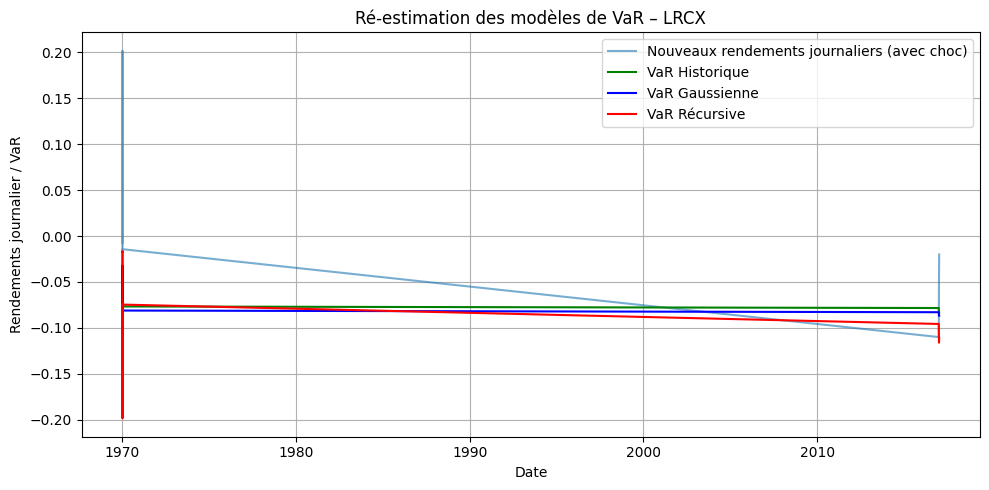

Analyse de l'impact du choc pour LOGI dans le Secteur Technologie


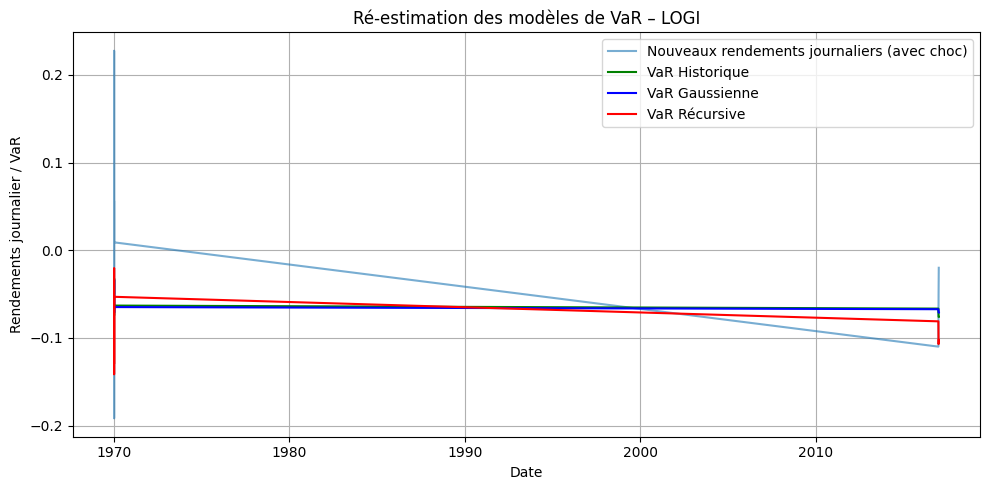

Analyse de l'impact du choc pour VLO dans le Secteur Énergie


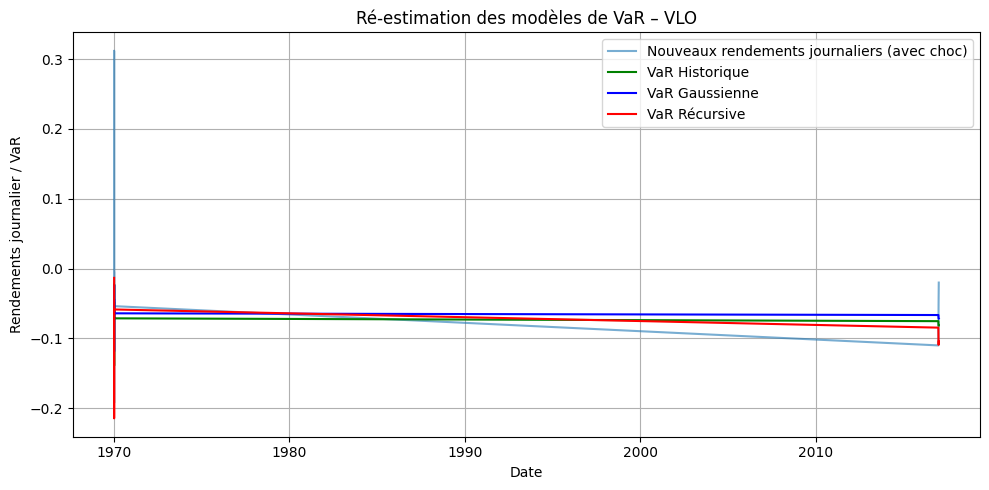

Analyse de l'impact du choc pour LYB dans le Secteur Énergie


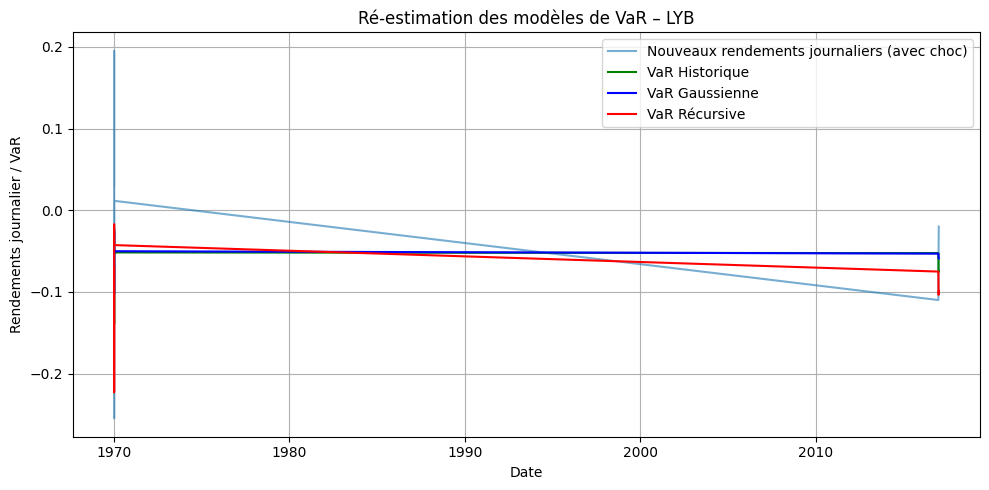

Analyse de l'impact du choc pour DVN dans le Secteur Énergie


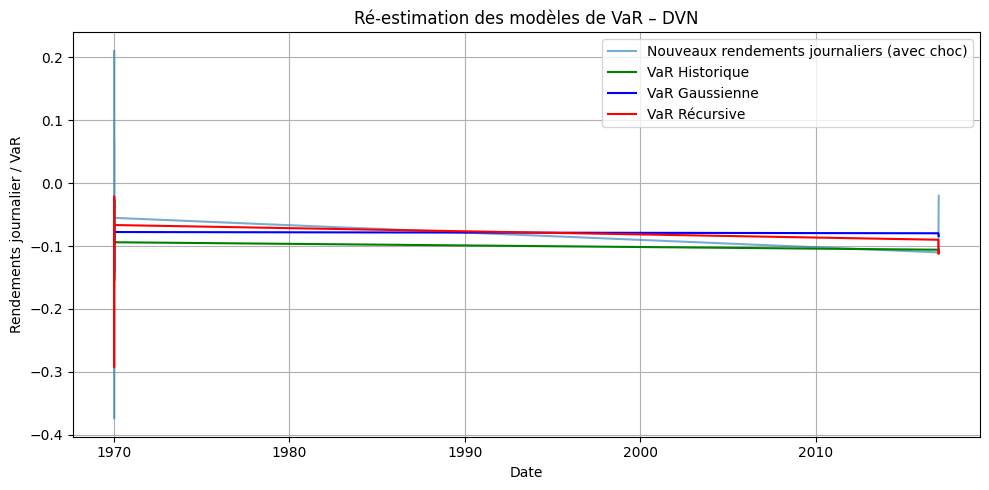

In [58]:
def analyze_shock_impact(returns_series, name, window=250):
    
    # Convertir en série pandas si ce n'est pas le cas
    if not isinstance(returns_series, pd.Series):
        returns_series = pd.Series(returns_series)
    
    # S'assurer que l'index est datetime
    if not isinstance(returns_series.index, pd.DatetimeIndex):
        returns_series.index = pd.to_datetime(returns_series.index)
    
    shock = generate_shock(returns_series.index[-1])
    
    # Calcule retour historique avec choc
    full_returns = pd.concat([returns_series, shock])
    full_returns.index = pd.to_datetime(full_returns.index, errors='coerce')
    full_returns = full_returns.dropna()
    full_returns = full_returns.sort_index()
    
    # Recalcule VaR après choc
    var_hist = full_returns.rolling(window).apply(var_historique)
    var_gauss = var_gaussienne(full_returns, window)
    var_ewma_series = var_ewma(full_returns)
    
    plt.figure(figsize=(10, 5))
    plt.plot(full_returns.index, full_returns, label="Nouveaux rendements journaliers (avec choc)", alpha=0.6)
    plt.plot(var_hist.index, var_hist, label="VaR Historique", color="green")
    plt.plot(var_gauss.index, var_gauss, label="VaR Gaussienne", color="blue")
    plt.plot(var_ewma_series.index, var_ewma_series, label="VaR Récursive", color="red")
    plt.title(f"Ré-estimation des modèles de VaR – {name}")
    plt.xlabel("Date")
    plt.ylabel("Rendements journalier / VaR")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return var_hist, var_gauss, var_ewma_series, full_returns

sectors = {
    'Indice de marché': ['SPX'],
    'Secteur Technologie': ['VRSN', 'LRCX', 'LOGI'],
    'Secteur Énergie': ['VLO', 'LYB', 'DVN']
}   

for sector, tickers in sectors.items():
    for ticker in tickers:
        print(f"Analyse de l'impact du choc pour {ticker} dans le {sector}")
        returns_series = titles_for_var[ticker]['ret'].dropna()
        analyze_shock_impact(returns_series, ticker)

## QUESTION f

In [59]:
def test_couverture(var_series, realized_returns, alpha=0.01):
    # Alignement des séries
    realized_returns, var_series = realized_returns.align(var_series, join='inner')

    # Violations : quand la perte est plus grande que la VaR
    violations = realized_returns < var_series

    T = len(var_series)
    nb_violations = violations.sum()

    # Statistique S du test de couverture
    S = (nb_violations - alpha * T) / ((alpha * (1 - alpha) * T) ** 0.5)

    return S, nb_violations, T

def perform_coverage_test(var_hist, var_gauss, var_ewma, returns, name):
    
    models = {
        'VaR Historique': var_hist,
        'VaR Gaussienne': var_gauss,
        'VaR EWMA': var_ewma
    }
    
    print(f"\nTest de couverture - {name}")
    for model_name, var_series in models.items():
        S, nb_viol, T = test_couverture(var_series, returns, alpha=0.01)
        print(f"{model_name} :")
        print(f"Statistique S = {S:.2f}")
        print(f"Violations = {nb_viol}/{T}")
        print()

# Tests de couverture par secteur
perform_coverage_test(var_hist_spx, var_gauss_spx, var_ewma_spx, full_returns_spx, "SPX")
perform_coverage_test(var_hist_tech, var_gauss_tech, var_ewma_tech, full_returns_tech, "Secteur Technologie")
perform_coverage_test(var_hist_energy, var_gauss_energy, var_ewma_energy, full_returns_energy, "Secteur Énergie")

NameError: name 'var_hist_spx' is not defined

## QUESTION g

In [60]:
def test_sequences(violations):
    violations = violations.dropna()

    # Convertit les booléens en int (1 = violation, 0 = pas violation)
    v = violations.astype(int).values

    # Nombre total de violations et non-violations
    n1 = v.sum()          # Violations
    n0 = len(v) - n1      # Non-violations

    # Nombre de séquences = transitions entre 0 et 1
    seq = 1 + np.sum(v[1:] != v[:-1])

    # Espérance et écart-type sous H0 
    expected = 1 + 2 * n0 * n1 / (n0 + n1)
    std = (2 * n0 * n1 * (2 * n0 * n1 - n0 - n1)) / ((n0 + n1)**2 * (n0 + n1 - 1))
    std = std**0.5

    Z = (seq - expected) / std

    return seq, expected, Z

def perform_sequences_test(var_hist, var_gauss, var_ewma, returns, name):
    
    models = {
        'VaR Historique': var_hist,
        'VaR Gaussienne': var_gauss,
        'VaR EWMA': var_ewma
    }
    
    print(f"\nTest de séquences - {name}")
    for model_name, var_series in models.items():
        aligned_returns, aligned_var = returns.align(var_series, join='inner')
        violations = aligned_returns < aligned_var
        runs_obs, runs_exp, Z = test_sequences(violations)

        print(f"{model_name} :")
        print(f"Runs observés : {runs_obs}")
        print(f"Runs attendus : {runs_exp:.2f}")
        print(f"Statistique Z : {Z:.2f}")
        print()

# Tests de séquences par secteur
perform_sequences_test(var_hist_spx, var_gauss_spx, var_ewma_spx, full_returns_spx, "SPX")
perform_sequences_test(var_hist_tech, var_gauss_tech, var_ewma_tech, full_returns_tech, "Secteur Technologie")
perform_sequences_test(var_hist_energy, var_gauss_energy, var_ewma_energy, full_returns_energy, "Secteur Énergie")

NameError: name 'var_hist_spx' is not defined